<img src="http://vision.skills.network/logo-light.png" width="400" alt="CV Studio logo"  />


# Transfer Learning with Convolutional Neural Networks for Image Classification — CV Studio + PyTorch (ResNet18)

**Short description:**  
This notebook performs transfer learning using a pretrained ResNet18 to classify images downloaded from CV Studio. It prepares data loaders, freezes pretrained layers, replaces the final fully-connected layer, trains the classifier with a learning-rate scheduler, reports results back to CV Studio, saves the model and runs a few sample predictions.

**Context:**

CV Studio is a fast, easy and collaborative open source image annotation tool for teams and individuals. In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset in the lab, then use this Network to train your model. We will use the Convolutional Network as a feature generator, only training the output layer.  In general, 100-200 images will give you a good starting point, and it only takes about half an hour.  Usually, the more images you add, the better your results, but it takes longer and the rate of improvement will decrease.

**Important Notices:**

* This notebook was run in the course environment; therefore, reproducibility is limited in a local environment. 
* The CV Studio license was limited; therefore, the implementation in this tool has already expired and cannot be shared in this notebook.

**Objectives**
- Initialize CV Studio client and download the dataset.
- Prepare PyTorch Dataset/DataLoader objects for training and validation.
- Use a pretrained ResNet18 model and adapt its final layer to the dataset class count.
- Train the model (with optional cyclic LR scheduler), evaluate on validation set and report metrics back to CV Studio.
- Save and upload the trained model to CV Studio and show sample predictions on local images.

**Notice about documentation:**  
The original notebook submission (course assignment) was kept intact. I have **only modified documentation (comments, headings, markdown)** and made **minimal, necessary corrections** to ensure the notebook runs without errors. All rights related to the lab/workshop design and original exercise belong exclusively to **IBM Corporation**. This notebook includes additional documentation for clarity, but the intellectual property of the original exercise is retained by IBM.


## Import Libraries and Define Auxiliary Functions


## 1) Dependencies & execution instructions

This section installs and imports required Python packages.  

**Recommended local execution steps:**

1. Create and activate a Python virtual environment:
   - `python -m venv venv`
   - `source venv/bin/activate` (macOS / Linux) or `venv\Scripts\activate` (Windows)
2. Install dependencies:
   - `pip install -r requirements.txt`
3. Launch Jupyter Notebook:
   - `jupyter notebook`
4. Open this notebook and run cells top-to-bottom.

**Note:** GPU (CUDA) is recommended for faster training; the notebook will use CUDA if available.

Libraries for OS and Cloud


In [1]:
import os
import uuid
import shutil
import json
from botocore.client import Config
import ibm_boto3
import copy
from datetime import datetime
from skillsnetwork import cvstudio 

Libraries for Data Processing and Visualization


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

Deep Learning Libraries


In [3]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

## 2) CV Studio client & dataset download

Initialize the CV Studio client, download the dataset with `cvstudioClient.downloadAll()`, and load the training/validation datasets via `getDataset()`. The notebook uses CV Studio helpers (skillsnetwork.cvstudio).


In [ ]:

# Get the Dataset
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()
# Download All Images
cvstudioClient.downloadAll()

100%|██████████| 197/197 [00:57<00:00,  3.45it/s]


In [9]:
percentage_train=0.9
train_set=cvstudioClient.getDataset(train_test='train',percentage_train=percentage_train)
val_set=cvstudioClient.getDataset(train_test='test',percentage_train=percentage_train)

defult transform for pretrained model resnet18
this is the training set
defult transform for pretrained model resnet18
this is the test set


Define our device as the first visible cuda device if we have CUDA available:


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)


the device type is cpu


## 3) Utility functions

Define helper functions for plotting training loss/accuracy (`plot_stuff`), showing image tensors (`imshow_`), and printing misclassified examples (`result`).

Plot train cost and validation accuracy:


In [ ]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()
    
    plt.show()

Plot the transformed image:


In [5]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

Compare the prediction and actual value:


In [6]:
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

## 4) Model setup

Load pretrained ResNet18, freeze parameters, replace final fully-connected layer with `nn.Linear(512, n_classes)`, move model to device (CUDA if available). Prepare `DataLoader` objects for train and validation sets, define `CrossEntropyLoss`, optimizer (`SGD`), and optional CyclicLR scheduler.

Dataset sample:


(224, 224, 3)


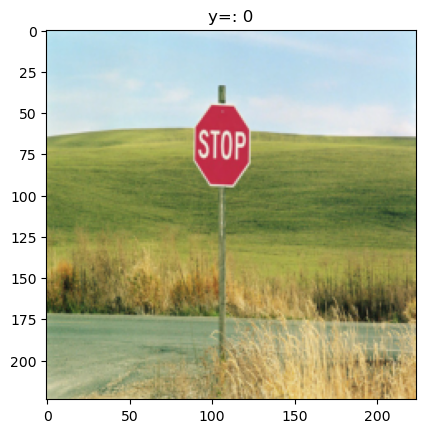

(224, 224, 3)


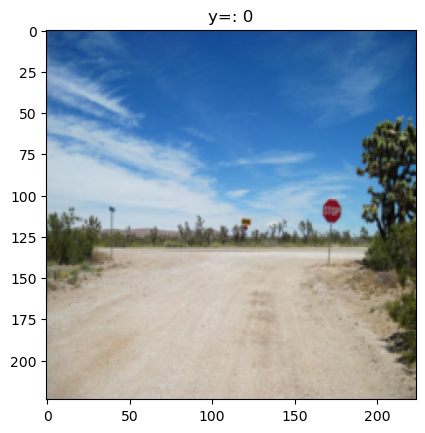

(224, 224, 3)


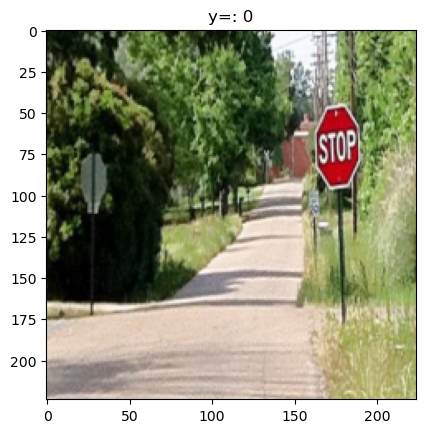

In [10]:
i=0

for x,y  in val_set:
    imshow_(x,"y=: {}".format(str(y.item())))
    i+=1
    if i==3:
        break

### Hyperparameters


<b>Epoch</b> indicates the number of passes of the entire training dataset, here we will set the number of epochs to 10:


In [11]:
n_epochs=10

<b>Batch size</b> is the number of training samples utilized in one iteration. If the batch size is equal to the total number of samples in the training set, then every epoch has one iteration. In Stochastic Gradient Descent, the batch size is set to one. A batch size of 32--512 data points seems like a good value.


In [12]:
batch_size=32

 <b>Learning rate</b> is used in the training of neural networks. Learning rate is a hyperparameter with a small positive value, often in the range between 0.0 and 1.0.


In [13]:
lr=0.000001

<b>Momentum</b> is a term used in the gradient descent algorithm to improve training results.


In [14]:
momentum=0.9

If you set to <code>lr_scheduler=True</code>  for every epoch use a learning rate scheduler changes the range of the learning rate from a maximum or minimum value. The learning rate usually decays over time.


In [15]:
lr_scheduler=True
base_lr=0.001
max_lr=0.01

### Model Configuration

 Load the pre-trained model resnet18. Set the parameter pretrained to true.


In [17]:
model = models.resnet18(pretrained=True)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Only the last layer of the network will be trained. The parameter <code>requires_grad</code> is set to <code>False</code>, the network is a fixed feature extractor.


In [ ]:
for param in model.parameters():
       param.requires_grad = False
    

Number of classes


In [19]:
n_classes=train_set.n_classes
n_classes

2

The output layer of model.fc of the neural network is replaced with a nn.Linear object, to classify <code>n_classes</code> different classes.


In [ ]:
model.fc = nn.Linear(512, n_classes)

Set device type


In [21]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Cross-entropy loss, or log loss, measures the performance of a classification model.


In [22]:
criterion = nn.CrossEntropyLoss()

Training loader and validation loader object.


In [23]:

train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

Optim package to define an Optimizer that will update the weights of the model. 


In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


Cyclical Learning Rates are used for the scheduler.


In [25]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

## 5) Training loop & reporting

`train_model()` trains for `n_epochs`, computes and records epoch loss and validation accuracy, keeps best model weights, and returns accuracy/loss lists and the best model. Results are reported back to CV Studio via `cvstudioClient.report()`. The final model is saved and uploaded with `cvstudioClient.uploadModel()`.

In [16]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

In [26]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|          | 0/10 [00:00<?, ?it/s]

The first epoch should take several minutes
epoch 0 done


 10%|█         | 1/10 [00:34<05:10, 34.50s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 0.7642156680425009
The validation accuracy for epoch 1: 0.6
epoch 1 done


 20%|██        | 2/10 [01:01<04:01, 30.13s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.6192821264266968
The validation accuracy for epoch 2: 0.95
epoch 2 done


 30%|███       | 3/10 [01:26<03:15, 27.97s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.42995019753774005
The validation accuracy for epoch 3: 0.9
epoch 3 done


 40%|████      | 4/10 [01:52<02:42, 27.08s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.37667275468508404
The validation accuracy for epoch 4: 0.85
epoch 4 done


 50%|█████     | 5/10 [02:17<02:12, 26.43s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.2599394644300143
The validation accuracy for epoch 5: 1.0
epoch 5 done


 60%|██████    | 6/10 [02:43<01:44, 26.08s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.2917134587963422
The validation accuracy for epoch 6: 1.0
epoch 6 done


 70%|███████   | 7/10 [03:09<01:17, 25.99s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.2533433722953002
The validation accuracy for epoch 7: 1.0
epoch 7 done


 80%|████████  | 8/10 [03:35<00:52, 26.11s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.20602868249018988
The validation accuracy for epoch 8: 1.0
epoch 8 done


 90%|█████████ | 9/10 [04:01<00:26, 26.04s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.22499693495531878
The validation accuracy for epoch 9: 0.9
epoch 9 done


100%|██████████| 10/10 [04:27<00:00, 26.78s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.18292882293462753
The validation accuracy for epoch 10: 1.0
elapsed time 268.2221894264221


## 6) Save model & sample inference

Save trained model to `model.pt`, upload it to CV Studio, and run sample inference on a list of local image files, showing predictions using `imshow_`.


Report back the results of the training run to CV Studio.


In [27]:


parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
    
    
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy={ 'accuracy': accuracy_list, 'loss': loss_list })

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


Save the model to model.pt


In [ ]:
torch.save(model.state_dict(), 'model.pt')
result = cvstudioClient.uploadModel('model.pt', {'numClasses': n_classes})

File Uploaded


Plot train cost and validation accuracy.


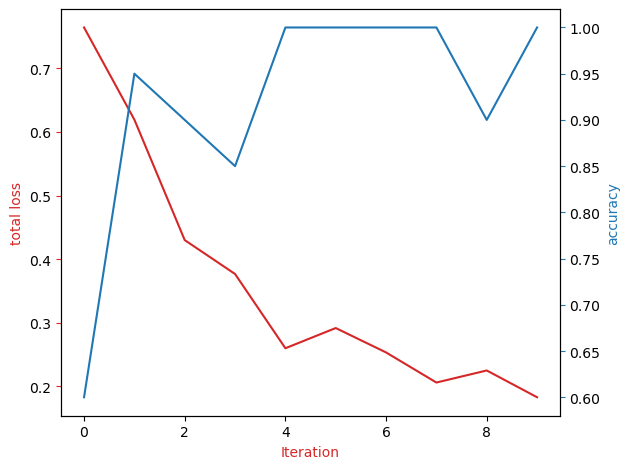

In [29]:
plot_stuff(loss_list,accuracy_list)

Load the model that performs best:  


In [30]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load( "model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
imageNames = ['stop_1.jpeg','stop_2.jpeg','not_stop_1.jpeg']
for imageName in imageNames:
    image = Image.open(imageName)
    transform = composed = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    x = transform(image)
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    # print(yhat)
    prediction = "Stop"
    if yhat == 1:
        prediction ="Not Stop"
    imshow_(transform(image),imageName+": Prediction = "+prediction)

## 7) Notes & reproducibility

- CV Studio helper `skillsnetwork.cvstudio` and `ibm_boto3` are required to download the dataset and report results. If running offline, replace dataset acquisition with a local Dataset class or local files.
- Training hyperparameters (lr, scheduler, batch_size, epochs) are set near the top; adjust to speed up or improve results.
- Some packages (e.g., `skillsnetwork` / CV Studio helpers) are specific to the course environment; if they are not available via pip in your local environment, download the dataset manually and use a local `Dataset` class to replace `cvstudioClient` calls.


## Authors


Joseph Santarcangelo.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2021-05-25        | 0.3     | Yasmine    | Modifies Multiple Areas |
| 2021-05-25        | 0.3     | Kathy      | Modified Multple Areas. |
| 2021-03-08        | 0.2     | Joseph     | Modified Multiple Areas |
| 2021-02-01        | 0.1     | Joseph     | Modified Multiple Areas |


Copyright © 2021 IBM Corporation. All rights reserved.
